ROUND 1 - Trading Strategy Simulation


We will analyze trading data for STARFRUIT, computes fair value, and simulates trades based on market signals.  
The goal is to evaluate profitability based on deviations from fair value.

In [1]:
from google.colab import files
uploaded = files.upload()


ModuleNotFoundError: No module named 'google'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import helpers

# Data Preparation

In [8]:
with open("data/round1.log", "r", encoding="utf-8") as f:
    content = f.readlines()

In [10]:
trades_df,activity_logs_df,sandbox_logs = helpers.wrangle_backtest(content)

In [11]:
trades_df = trades_df[trades_df["symbol"] == "STARFRUIT"]

In [13]:
# Label each trade as buy or sell
def get_side(row):
    if row["buyer"] == "SUBMISSION":  return "SELL"
    elif row["seller"] == "SUBMISSION":  return "BUY"
    else: return "NONE"

trades_df["side"] = trades_df.apply(get_side, axis=1)

In [14]:
# add + for buy and - for sell
trades_df["signed_qty"] = trades_df.apply(lambda row: row["quantity"] if row["side"] == "BUY" else row["quantity"], axis=1)

# how much we are holding (inventory)
trades_df["inventory"] = trades_df["signed_qty"].cumsum()

# cash goes down when buying, up when selling
trades_df["cash_flow"] = trades_df.apply(lambda row: -row["price"] * row["quantity"] if row["side"] == "BUY" else row["price"] * row["quantity"],axis=1)

# total money
trades_df["cash"] = trades_df["cash_flow"].cumsum()

# our final result
final_pnl = -trades_df["cash"].iloc[-1]
print("Final PnL:", final_pnl)

Final PnL: -48919296


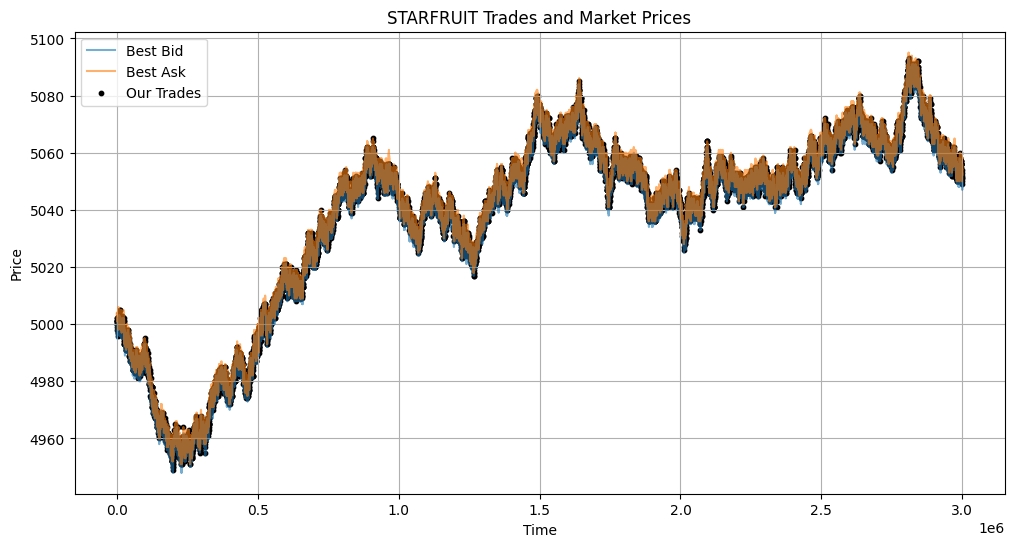

In [15]:
# extract and process market data for starfruit
market_df = activity_logs_df[activity_logs_df["product"] == "STARFRUIT"].copy()
market_df["timestamp"] = pd.to_numeric(market_df["timestamp"], errors="coerce")
market_df["bid"] = pd.to_numeric(market_df["bid_price_1"], errors="coerce")
market_df["ask"] = pd.to_numeric(market_df["ask_price_1"], errors="coerce")

# compute fair value from bid and ask
market_df["fair_value"] = (market_df["bid"] + market_df["ask"]) / 2

# prepare trade data
trades_df["timestamp"] = pd.to_numeric(trades_df["timestamp"], errors="coerce")
trades_df["price"] = pd.to_numeric(trades_df["price"], errors="coerce")

# plot trades and market prices
plt.figure(figsize=(12, 6))
plt.plot(market_df["timestamp"], market_df["bid"], label="Best Bid", alpha=0.6)
plt.plot(market_df["timestamp"], market_df["ask"], label="Best Ask", alpha=0.6)
plt.scatter(trades_df["timestamp"], trades_df["price"], color="black", s=10, label="Our Trades")

plt.title("STARFRUIT Trades and Market Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# Compute fair value
market_df["fair_value"] = (market_df["bid"] + market_df["ask"]) / 2

# Define a small threshold for signal generation
threshold = 0.001

# Basic comparison with fair value — no subtraction
market_df["buy_signal"] = market_df["ask"] < market_df["fair_value"]
market_df["sell_signal"] = market_df["bid"] > market_df["fair_value"]

# See how many we get now
print("Buy signals:", market_df["buy_signal"].sum())
print("Sell signals:", market_df["sell_signal"].sum())


Buy signals: 0
Sell signals: 0


In [17]:
print(market_df[["bid", "ask", "fair_value"]].head(10))

0    bid   ask  fair_value
2   4997  5003      5000.0
4   5000  5004      5002.0
6   4997  5003      5000.0
8   4996  5003      4999.5
10  4995  5002      4998.5
12  5001  5003      5002.0
14  4996  5003      4999.5
16  4997  5003      5000.0
18  5002  5003      5002.5
20  5001  5004      5002.5


### Playing with Kalman Filter

In [22]:
import pykalman

In [23]:
kf = pykalman.KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=0,
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

In [27]:
mids = market_df["mid_price"].apply(pd.to_numeric)

In [29]:
state_means, state_covariances = kf.filter(mids.values)
kalman_avg = state_means.flatten()

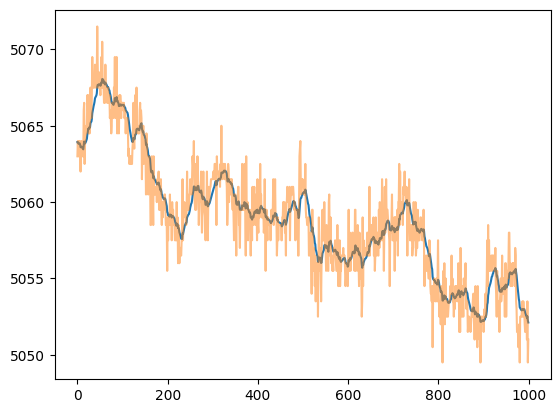

In [36]:
plt.plot(kalman_avg[-1000:])
plt.plot(mids[-1000:].values, alpha = 0.5)

The Kalman filter works well. It is a popular technique in signal processing

In [37]:
def ema(close, period=20):
    return close.ewm(span=period, adjust=False).mean()

<Axes: >

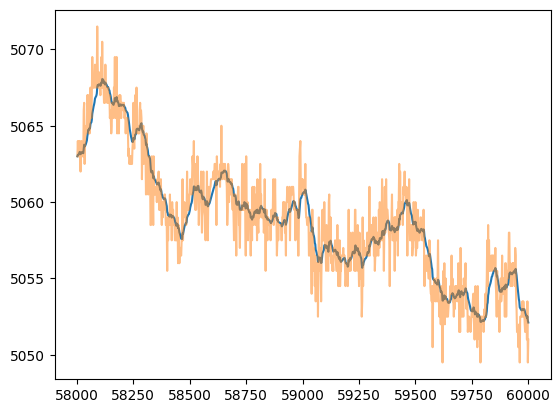

In [43]:
ema(mids[-1000:]).plot()
mids[-1000:].plot(alpha = 0.5)

EMA is less sensitive and in general worse for the purposes of trading. It is basically an averaage and worse in dtectinf the "mid" of the noise

In [44]:
from scipy.signal import savgol_filter

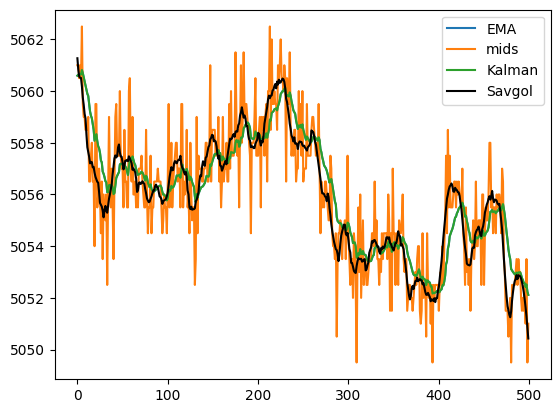

In [47]:
last_num = 500

EMA_VALUES = ema(mids)[-last_num:].values
SAVGOL_VALUES = savgol_filter(mids, 20, 2)[-last_num:]
KALMAN_VALUES = kalman_avg[-last_num:]
MIDS = mids[-last_num:].values

plt.plot(EMA_VALUES, label = "EMA")
plt.plot(MIDS, label = "mids")
plt.plot(KALMAN_VALUES, label = "Kalman")
plt.plot(SAVGOL_VALUES, color = "black", label = "Savgol")
plt.legend()

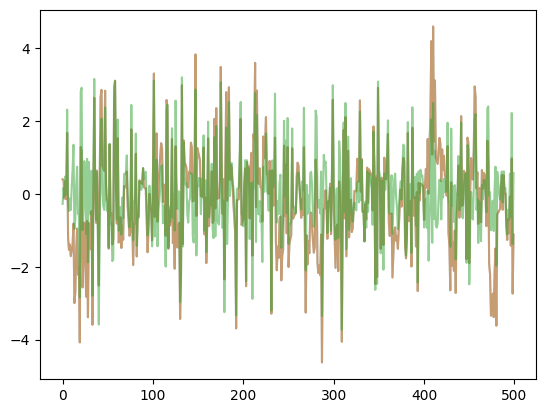

In [57]:
plt.plot(MIDS - EMA_VALUES, alpha = 0.5, label = "EMA signal")
plt.plot(MIDS - KALMAN_VALUES, alpha = 0.5, label = "Kalman signal")
plt.plot(MIDS - SAVGOL_VALUES, alpha = 0.5, label = "Savgol signal")

In [63]:
savgol_deviation = MIDS - SAVGOL_VALUES

In [65]:
z_scores = (savgol_deviation - savgol_deviation.mean()) / savgol_deviation.std()

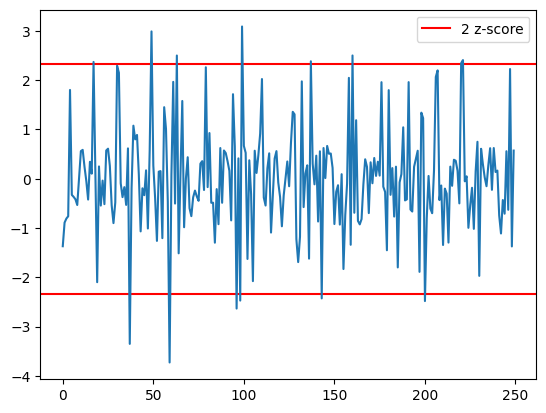

In [68]:
savgol_mid_spread_std = savgol_deviation.std()
plt.axhline(2*savgol_mid_spread_std, color = "red")
plt.axhline(-2*savgol_mid_spread_std, color = "red", label = "2 z-score")
plt.plot(savgol_deviation[-250:])
plt.legend()


### CONCLUSION

We calculated a fair value based on the bid and ask prices, generated buy/sell signals based on the spread deviation. It is hard to asses what gives the best signal, but it is a good starting point for first algorithms and checking on trading data.